In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

### 4.1

In [2]:
# loading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

The number of samples in the training set is:  60000
The number of samples in the test set is:  10000


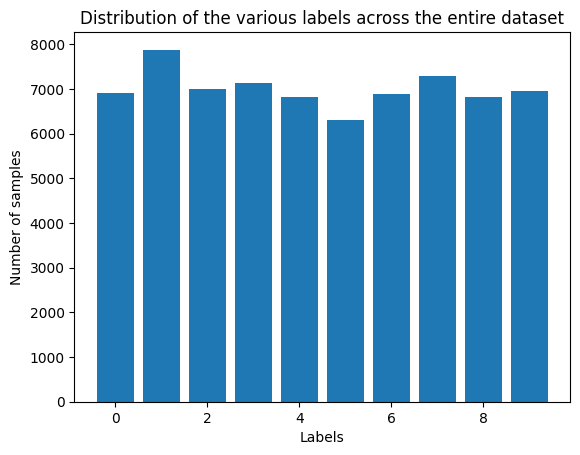

In [3]:
# Drawing a graph that shows the distribution of the various labels across the entire dataset.
print('The number of samples in the training set is: ', len(train_dataset))
print('The number of samples in the test set is: ', len(test_dataset))
train_labels = train_dataset.targets
test_labels = test_dataset.targets
labels = torch.cat((train_labels, test_labels))
unique, counts = torch.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of the various labels across the entire dataset')
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.show()

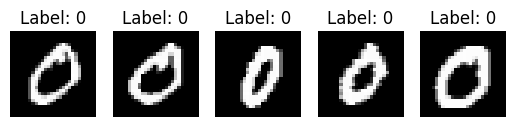

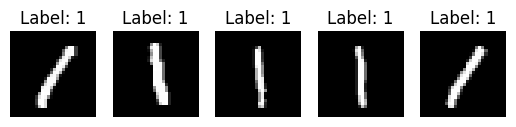

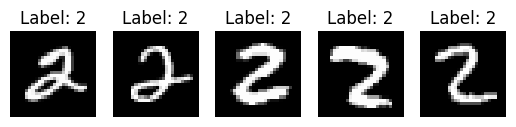

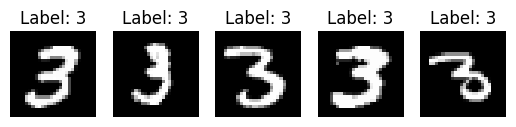

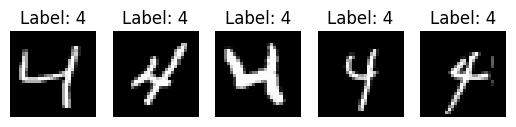

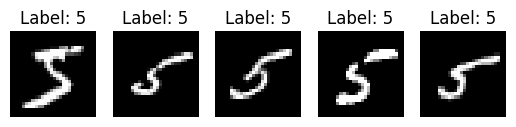

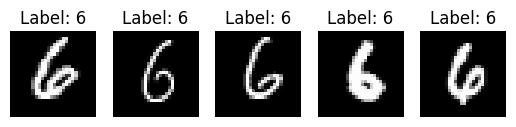

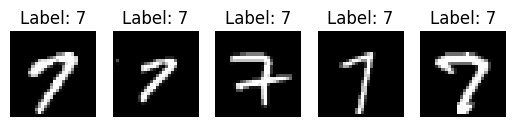

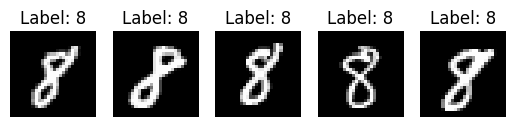

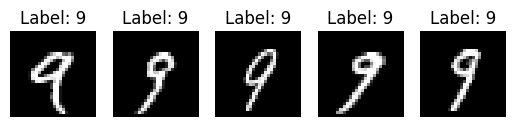

In [4]:
for i in range(10):
    count = 0
    for j in range(len(train_dataset)):
        if train_dataset[j][1] == i:
            plt.subplot(1, 5, count + 1)
            plt.imshow(train_dataset[j][0].squeeze(0), cmap='gray')
            plt.title('Label: ' + str(train_dataset[j][1]))
            plt.axis('off')
            count += 1
        if count == 5:
            break
    plt.show()

In [5]:
imbalance_ratio = counts[1] / counts[5]
print('The imbalance ratio is: ', imbalance_ratio)
print('The number of samples in the majority class is: ', counts[1])
print('The number of samples in the minority class is: ', counts[5])


The imbalance ratio is:  tensor(1.2477)
The number of samples in the majority class is:  tensor(7877)
The number of samples in the minority class is:  tensor(6313)


In [6]:
# partitioning train dataset into train and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

### 4.2

In [7]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, kernel_size=5, dropout=0.2, stride=2, padding=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        out_size1 = int(((28 + 2 * padding - kernel_size) / stride) + 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        out_size1 = int(((out_size1 - 2) / 2) + 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        out_size2 = int(((out_size1 + 2 * padding - kernel_size) / stride) + 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        out_size2 = int(((out_size2 - 2) / 2) + 1)
        self.fc1 = nn.Linear(64 * out_size2 * out_size2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [8]:
def train(train_dataset, val_dataset,epochs=10,batch_size=64,lr=0.001, dropout=0.2, kernel_size=5, stride=1, padding=1, verbose=True):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    model = CNN(kernel_size=kernel_size, dropout=dropout, stride=stride, padding=padding)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)
        if verbose:
            print('Epoch: ', epoch + 1, 'Train Loss: ', train_loss[-1], 'Train Accuracy: ', train_acc[-1])
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)
        if verbose:
            print('Epoch: ', epoch + 1, 'Validation Loss: ', val_loss[-1], 'Validation Accuracy: ', val_acc[-1])
    return train_loss, val_loss, train_acc, val_acc,model

In [9]:
train_loss, val_loss, train_acc, val_acc,model = train(train_dataset, val_dataset, epochs=10, batch_size=64, lr=0.001, dropout=0.2, kernel_size=5, stride=1, padding=1, verbose=True)

Epoch:  1 Train Loss:  0.2908950170818859 Train Accuracy:  0.90756
Epoch:  1 Validation Loss:  0.08192574797838831 Validation Accuracy:  0.975
Epoch:  2 Train Loss:  0.0827012106097694 Train Accuracy:  0.97528
Epoch:  2 Validation Loss:  0.06489016041126262 Validation Accuracy:  0.9795
Epoch:  3 Train Loss:  0.05847718851248403 Train Accuracy:  0.98374
Epoch:  3 Validation Loss:  0.04412723364147942 Validation Accuracy:  0.9874
Epoch:  4 Train Loss:  0.04654442017046137 Train Accuracy:  0.98654
Epoch:  4 Validation Loss:  0.044647822771714495 Validation Accuracy:  0.9879
Epoch:  5 Train Loss:  0.03690391434709389 Train Accuracy:  0.98872
Epoch:  5 Validation Loss:  0.040022087125493225 Validation Accuracy:  0.9886
Epoch:  6 Train Loss:  0.03188979460520919 Train Accuracy:  0.99106
Epoch:  6 Validation Loss:  0.040853210495025584 Validation Accuracy:  0.9894
Epoch:  7 Train Loss:  0.0265950955929157 Train Accuracy:  0.99224
Epoch:  7 Validation Loss:  0.03614474015708406 Validation Accu

In [10]:
# feature map visualization
def visualize_feature_map(model, layer_num, img):
    model.eval()
    # first convlutinal layer
    feature_map1 = model.pool1(torch.nn.functional.relu(model.conv1(img)))
    # second convlutinal layer
    feature_map2 = model.pool2(torch.nn.functional.relu(model.conv2(feature_map1)))
    if layer_num == 1:
        feature_map = feature_map1
    else:
        feature_map = feature_map2
    plt.figure(figsize=(10, 10))
    for i in range(len(feature_map[0])):
        plt.subplot(8, 8, i + 1)
        plt.imshow(feature_map[0][i].detach().numpy(), cmap='gray')
        plt.axis('off')

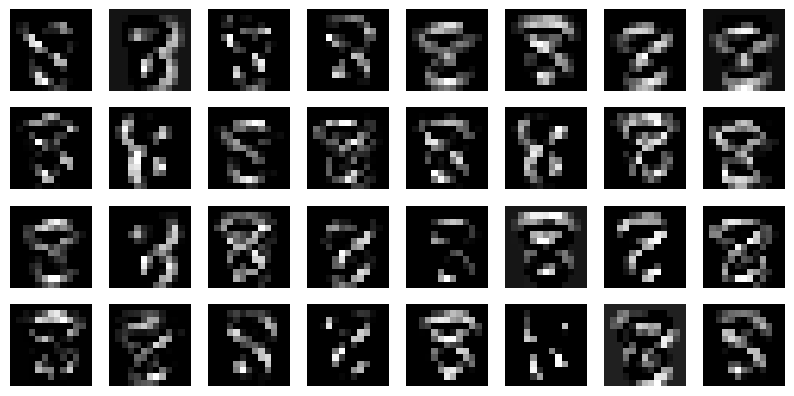

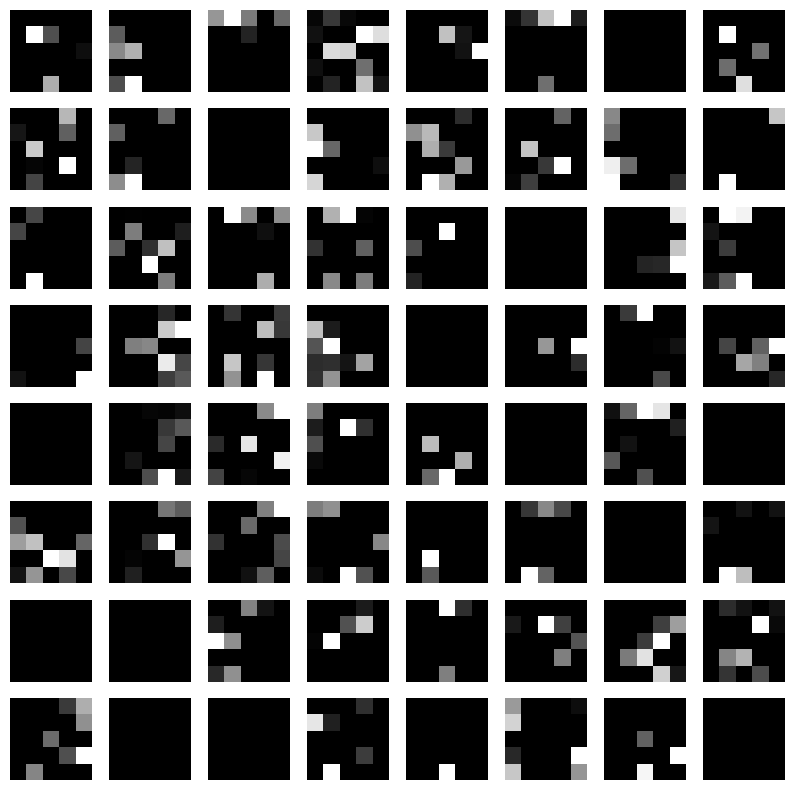

In [13]:
# visualizing the feature maps of the first convolutional layer
visualize_feature_map(model, 1, train_dataset[5][0].unsqueeze(0))

# visualizing the feature maps of the second convolutional layer
visualize_feature_map(model, 2, train_dataset[5][0].unsqueeze(0))

### 4.3

In [41]:
# hyperparameter tuning
import wandb
epochs = [5, 10]
batch_size = [64, 128]
lr = [0.001, 0.01]
dropout = [0.2, 0.5]
kernel_size = [3, 5]
stride = [1, 2]
padding = [1, 2]
wandb.init(project='Q_4', entity='shravya1051')
for e in epochs:
    for b in batch_size:
        for l in lr:
            for d in dropout:
                for k in kernel_size:
                    for s in stride:
                        for p in padding:
                            train_loss, val_loss, train_acc, val_acc,model = train(train_dataset, val_dataset, epochs=e, batch_size=b, lr=l, dropout=d, kernel_size=k, stride=s, padding=p, verbose=False)
                            print('epochs = ', e, 'batch_size = ', b, 'lr = ', l, 'dropout = ', d, 'kernel_size = ', k, 'stride = ', s, 'padding = ', p)
                            print('Train Loss: ', train_loss[-1], 'Validation Loss: ', val_loss[-1], 'Train Accuracy: ', train_acc[-1], 'Validation Accuracy: ', val_acc[-1])
                            wandb.log({'epochs': e, 'batch_size': b, 'lr': l, 'dropout': d, 'kernel_size': k, 'stride': s, 'padding': p
                                       ,'train_loss': train_loss[-1], 'val_loss': val_loss[-1], 'train_acc': train_acc[-1], 'val_acc': val_acc[-1]})

epochs =  5 batch_size =  64 lr =  0.001 dropout =  0.2 kernel_size =  3 stride =  1 padding =  1
Train Loss:  0.03929039168343081 Validation Loss:  0.04337613898636974 Train Accuracy:  0.98886 Validation Accuracy:  0.9875
epochs =  5 batch_size =  64 lr =  0.001 dropout =  0.2 kernel_size =  3 stride =  1 padding =  2
Train Loss:  0.042165281350479956 Validation Loss:  0.04467851488708643 Train Accuracy:  0.98698 Validation Accuracy:  0.9877
epochs =  5 batch_size =  64 lr =  0.001 dropout =  0.2 kernel_size =  3 stride =  2 padding =  1
Train Loss:  0.07211353887251253 Validation Loss:  0.0705731212380965 Train Accuracy:  0.97868 Validation Accuracy:  0.9784
epochs =  5 batch_size =  64 lr =  0.001 dropout =  0.2 kernel_size =  3 stride =  2 padding =  2
Train Loss:  0.0909816330403585 Validation Loss:  0.08571757625930818 Train Accuracy:  0.97306 Validation Accuracy:  0.9731
epochs =  5 batch_size =  64 lr =  0.001 dropout =  0.2 kernel_size =  5 stride =  1 padding =  1
Train Loss:

In [16]:
# Best Parameters : epochs =  10 batch_size =  128 lr =  0.001 dropout =  0.2 kernel_size =  5 stride =  1 padding =  2
# training the model with the best parameters
train_loss, val_loss, train_acc, val_acc,final_model = train(train_dataset, val_dataset, epochs=10, batch_size=128, lr=0.001, dropout=0.2, kernel_size=5, stride=1, padding=2, verbose=True)

Epoch:  1 Train Loss:  0.35107023663380565 Train Accuracy:  0.8871
Epoch:  1 Validation Loss:  0.1189562164577125 Validation Accuracy:  0.9638
Epoch:  2 Train Loss:  0.08499707525972362 Train Accuracy:  0.97542
Epoch:  2 Validation Loss:  0.05327209521709835 Validation Accuracy:  0.984
Epoch:  3 Train Loss:  0.060698201586885374 Train Accuracy:  0.98248
Epoch:  3 Validation Loss:  0.043355124195023804 Validation Accuracy:  0.9883
Epoch:  4 Train Loss:  0.04544608511418924 Train Accuracy:  0.98692
Epoch:  4 Validation Loss:  0.042320042361189976 Validation Accuracy:  0.9872
Epoch:  5 Train Loss:  0.03936086729218912 Train Accuracy:  0.98858
Epoch:  5 Validation Loss:  0.04323335113283836 Validation Accuracy:  0.9886
Epoch:  6 Train Loss:  0.02996513655449709 Train Accuracy:  0.99074
Epoch:  6 Validation Loss:  0.04131129293855798 Validation Accuracy:  0.9888
Epoch:  7 Train Loss:  0.027509039165029336 Train Accuracy:  0.99156
Epoch:  7 Validation Loss:  0.048911087358623886 Validation A

### 4.4

In [10]:
# Testing the model

from sklearn.metrics import classification_report
def per_class_accuracy(y_true, y_pred):
    per_class_acc = []
    for i in range(10):
        total = 0
        correct = 0
        for j in range(len(y_true)):
            if y_true[j] == i:
                total += 1
                if y_pred[j] == i:
                    correct += 1
        per_class_acc.append(correct / total)
    return per_class_acc

def test(test_dataset, model):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted)
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: ', correct / total)
    print('Classification Report: ')
    print(classification_report(y_true, y_pred))
    print('Per-class accuracy: ')
    print(per_class_accuracy(y_true, y_pred))


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
# Testing the best model
test(test_dataset, final_model)

Accuracy of the network on the test images:  0.9926
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Per-class accuracy: 
[0.996938775510204, 0.9964757709251101, 0.999031007751938, 0.995049504950495, 0.994908350305499, 0.9865470852017937, 0.9874739039665971, 0.99416

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion_matrix_visualization(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

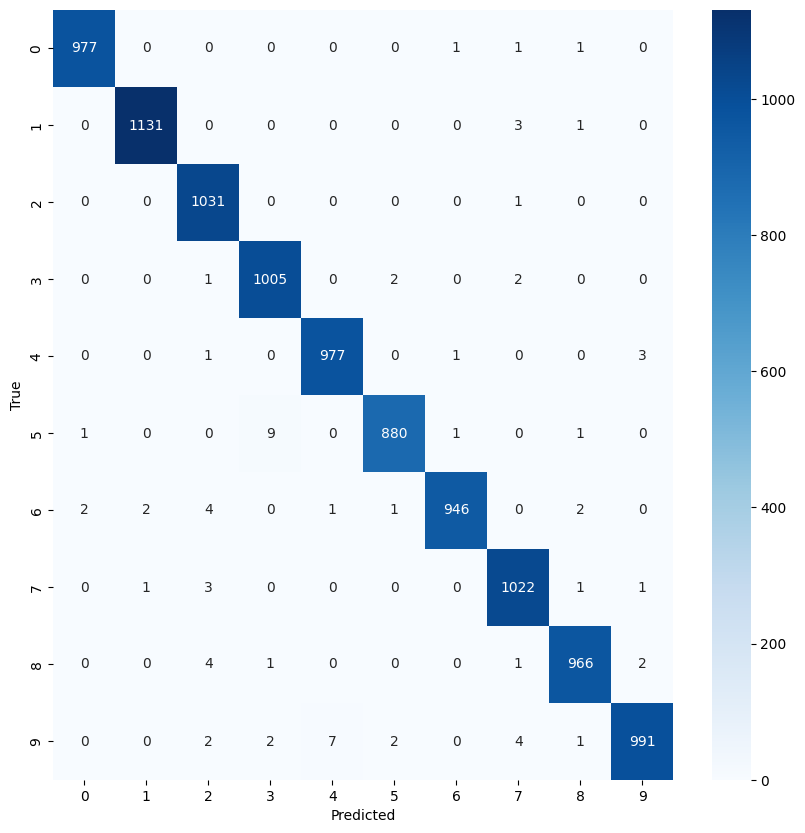

In [21]:
y_true = []
y_pred = []
for i in range(len(test_dataset)):
    y_true.append(test_dataset[i][1])
    y_pred.append(torch.argmax(final_model(test_dataset[i][0].unsqueeze(0))).item())

confusion_matrix_visualization(y_true, y_pred)


In [12]:
def misclassified_images(y_true, y_pred):
    misclassified = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            misclassified.append(i)
    return misclassified

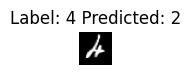

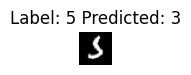

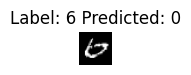

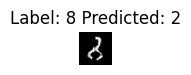

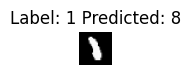

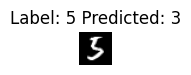

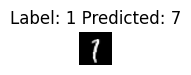

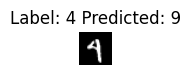

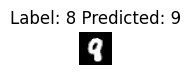

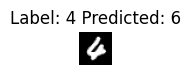

In [34]:
misclassified = misclassified_images(y_true, y_pred)
for i in range(10):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_dataset[misclassified[i]][0].squeeze(0), cmap='gray')
    plt.title('Label: ' + str(test_dataset[misclassified[i]][1]) + ' Predicted: ' + str(y_pred[misclassified[i]]))
    plt.axis('off')
plt.show()

- The model makes incorrect predictions when the digits are not clearly visible or when the digits are written in a different style.
- The model also makes incorrect predictions when the digits are written in a different orientation.

### 4.5

In [41]:
import scipy.io
import numpy as np

mat = scipy.io.loadmat('mnist-with-awgn.mat')
noisy_train = mat['train_x']
noisy_train_labels = mat['train_y']
noisy_test = mat['test_x']
noisy_test_labels = mat['test_y']

In [42]:
noisy_train = np.reshape(noisy_train, (60000,1, 28, 28))
noisy_train_labels = np.argmax(noisy_train_labels, axis=1).reshape(60000,1)
noisy_test = np.reshape(noisy_test, (10000,1, 28, 28))
noisy_test_labels = np.argmax(noisy_test_labels, axis=1).reshape(10000,1)

noisy_train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(noisy_train).float(), torch.from_numpy(noisy_train_labels).long().squeeze())
noisy_test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(noisy_test).float(), torch.from_numpy(noisy_test_labels).long().squeeze())


In [43]:
# partitioning train dataset into train and validation sets
noisy_train_dataset, noisy_val_dataset = torch.utils.data.random_split(noisy_train_dataset, [50000, 10000])

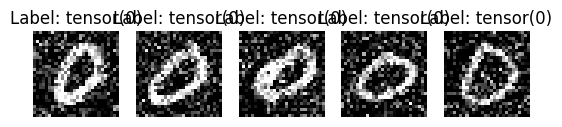

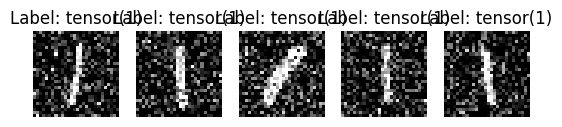

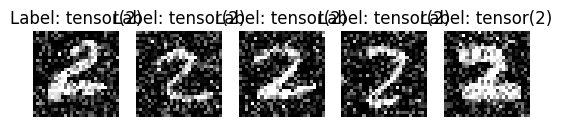

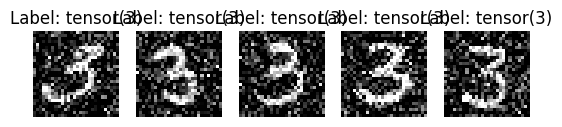

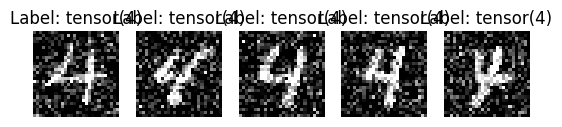

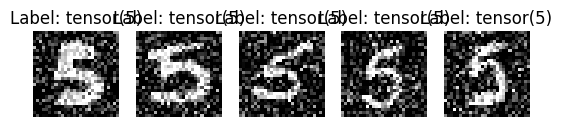

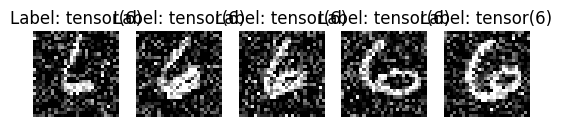

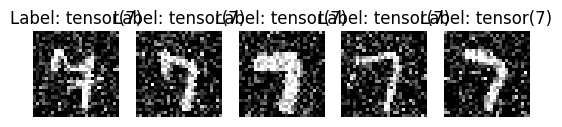

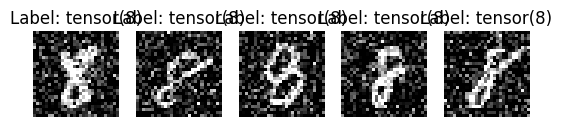

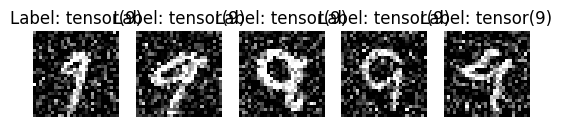

In [44]:
# visualize the noisy images
for i in range(10):
    count = 0
    for j in range(len(noisy_train_dataset)):
        if noisy_train_dataset[j][1] == i:
            plt.subplot(1, 5, count + 1)
            plt.imshow(noisy_train_dataset[j][0].squeeze(0), cmap='gray')
            plt.title('Label: ' + str(noisy_train_dataset[j][1]))
            plt.axis('off')
            count += 1
        if count == 5:
            break
    plt.show()

In [45]:
# training the model on the noisy dataset with the best parameters
train_loss, val_loss, train_acc, val_acc,noisy_model = train(noisy_train_dataset, noisy_val_dataset, epochs=10, batch_size=128, lr=0.001, dropout=0.2, kernel_size=5, stride=1, padding=2, verbose=True)

Epoch:  1 Train Loss:  0.6747352751472112 Train Accuracy:  0.79176
Epoch:  1 Validation Loss:  0.19445212553196314 Validation Accuracy:  0.9413
Epoch:  2 Train Loss:  0.23764786088024564 Train Accuracy:  0.92764
Epoch:  2 Validation Loss:  0.17241250138871278 Validation Accuracy:  0.9501
Epoch:  3 Train Loss:  0.18131539715296777 Train Accuracy:  0.9448
Epoch:  3 Validation Loss:  0.1504330322665127 Validation Accuracy:  0.9528
Epoch:  4 Train Loss:  0.15992851601079908 Train Accuracy:  0.95192
Epoch:  4 Validation Loss:  0.13910383816006816 Validation Accuracy:  0.9553
Epoch:  5 Train Loss:  0.13643454167220143 Train Accuracy:  0.95764
Epoch:  5 Validation Loss:  0.1203209415366991 Validation Accuracy:  0.9619
Epoch:  6 Train Loss:  0.13102422216359308 Train Accuracy:  0.95894
Epoch:  6 Validation Loss:  0.13676599969592276 Validation Accuracy:  0.9593
Epoch:  7 Train Loss:  0.11900745895798401 Train Accuracy:  0.96376
Epoch:  7 Validation Loss:  0.12028860402163825 Validation Accurac

In [46]:
# Testing the model on the noisy dataset
test(noisy_test_dataset, noisy_model)

Accuracy of the network on the test images:  0.9732
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.98      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Per-class accuracy: 
[0.986734693877551, 0.9859030837004406, 0.9612403100775194, 0.9861386138613861, 0.9653767820773931, 0.9742152466367713, 0.975991649269311, 0.983

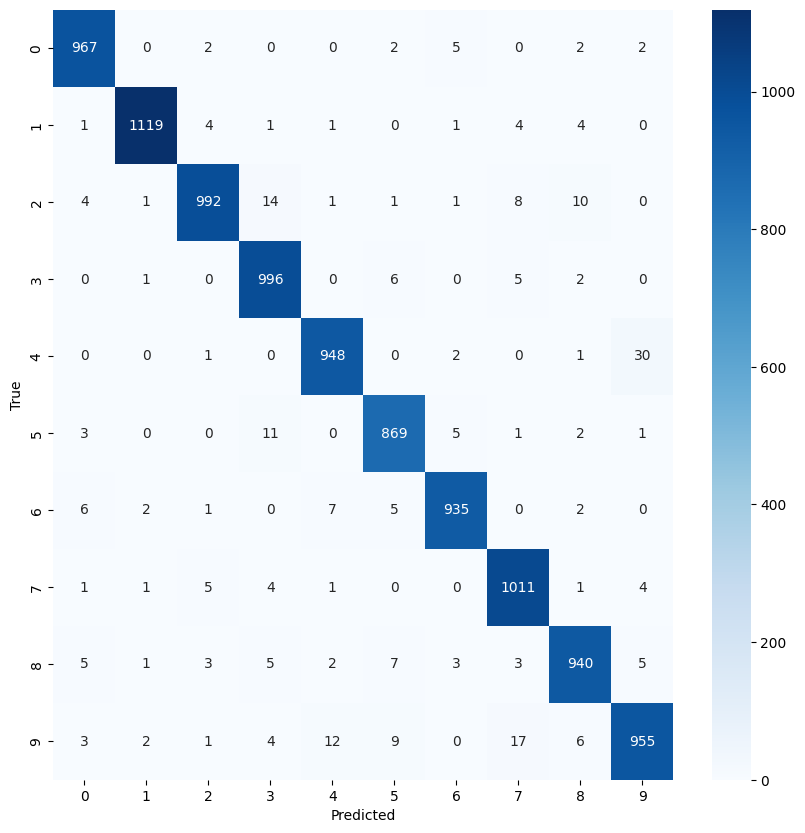

In [47]:
y_true = []
y_pred = []
for i in range(len(noisy_test_dataset)):
    y_true.append(noisy_test_dataset[i][1])
    y_pred.append(torch.argmax(noisy_model(noisy_test_dataset[i][0].unsqueeze(0))).item())

confusion_matrix_visualization(y_true, y_pred)

### 4.6

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
def add_noise(dataset,std):
    noisy_dataset = []
    for i in range(len(dataset)):
        noisy_dataset.append(dataset[i][0] + torch.randn(dataset[i][0].shape) * std)
    return noisy_dataset

noise_stddev = 0.4
noisy_mnist_train = add_noise(train_dataset, noise_stddev)
noisy_mnist_val = add_noise(val_dataset, noise_stddev)
noisy_mnist_test = add_noise(test_dataset, noise_stddev)

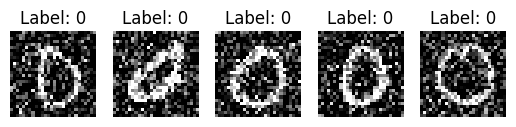

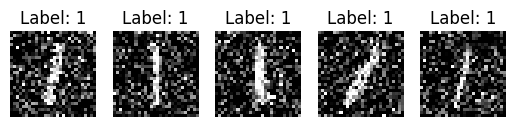

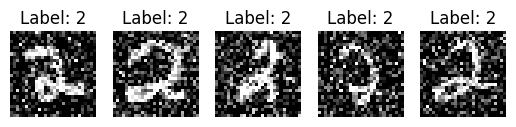

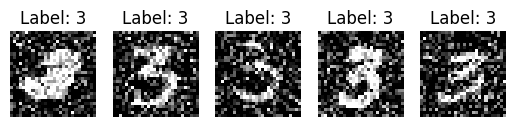

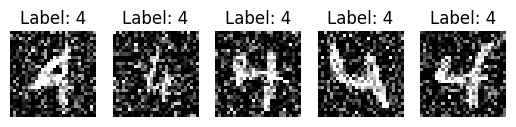

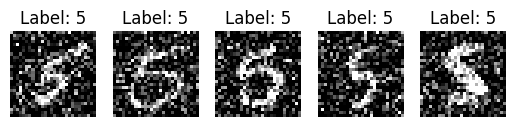

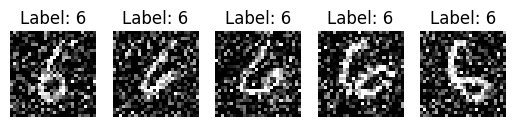

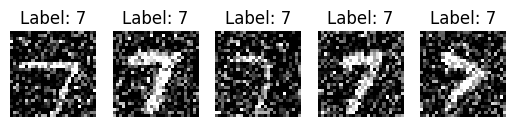

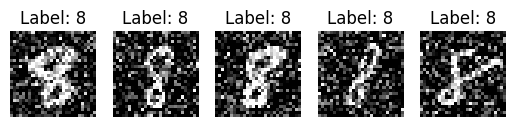

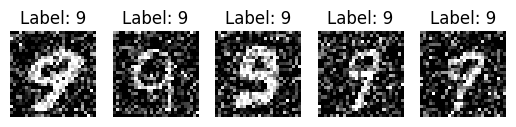

In [19]:
noisy_mnist_train = torch.stack([tup[0] for tup in noisy_mnist_train])
noisy_mnist_val = torch.stack([tup[0] for tup in noisy_mnist_val])
noisy_mnist_test = torch.stack([tup[0] for tup in noisy_mnist_test])
noisy_mnist_train=torch.clamp(noisy_mnist_train,0.,1.)
noisy_mnist_val=torch.clamp(noisy_mnist_val,0.,1.)
noisy_mnist_test=torch.clamp(noisy_mnist_test,0.,1.)
for i in range(10):
    count = 0
    for j in range(len(noisy_mnist_train)):
        if train_dataset[j][1] == i:
            plt.subplot(1, 5, count + 1)
            plt.imshow(noisy_mnist_train[j].squeeze(0), cmap='gray')
            plt.title('Label: ' + str(train_dataset[j][1]))
            plt.axis('off')
            count += 1
        if count == 5:
            break
    plt.show()

In [20]:
print(noisy_mnist_train.shape)

torch.Size([50000, 28, 28])


In [21]:
noisy_mnist_train = noisy_mnist_train.unsqueeze(1)
noisy_mnist_val = noisy_mnist_val.unsqueeze(1)
noisy_mnist_test = noisy_mnist_test.unsqueeze(1)
autoencoder_train_dataset = torch.utils.data.TensorDataset(
    noisy_mnist_train,
    torch.stack([sample[0] for sample in train_dataset])
)

autoencoder_val_dataset = torch.utils.data.TensorDataset(
    noisy_mnist_val,
    torch.stack([sample[0] for sample in val_dataset])
)

autoencoder_test_dataset = torch.utils.data.TensorDataset(
    noisy_mnist_test,
    torch.stack([sample[0] for sample in test_dataset])
)

In [22]:
def train_autoencoder(train_dataset, val_dataset, epochs=10, batch_size=64, lr=0.001, verbose=True):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    model = Autoencoder()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))
        if verbose:
            print('Epoch: ', epoch + 1, 'Train Loss: ', train_loss[-1])
        model.eval()
        running_loss = 0.0
        for i, data in enumerate(val_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        val_loss.append(running_loss / len(val_loader))
        if verbose:
            print('Epoch: ', epoch + 1, 'Validation Loss: ', val_loss[-1])
    return train_loss, val_loss, model

In [23]:
print(autoencoder_train_dataset[0][0].shape)

torch.Size([1, 28, 28])


In [24]:
# training the autoencoder
train_loss, val_loss, autoencoder_model = train_autoencoder(autoencoder_train_dataset, autoencoder_val_dataset, epochs=10, batch_size=128, lr=0.001, verbose=True)

Epoch:  1 Train Loss:  0.012354239005633556
Epoch:  1 Validation Loss:  0.008252790722335819
Epoch:  2 Train Loss:  0.007854657740715672
Epoch:  2 Validation Loss:  0.0076133826323136495
Epoch:  3 Train Loss:  0.007491402872278333
Epoch:  3 Validation Loss:  0.007371477370115021
Epoch:  4 Train Loss:  0.007323106380460589
Epoch:  4 Validation Loss:  0.0072343263279976725
Epoch:  5 Train Loss:  0.007201789822334143
Epoch:  5 Validation Loss:  0.007408208708880069
Epoch:  6 Train Loss:  0.0071136790203869035
Epoch:  6 Validation Loss:  0.007136346501168571
Epoch:  7 Train Loss:  0.007032650463340228
Epoch:  7 Validation Loss:  0.007036934229486351
Epoch:  8 Train Loss:  0.006985878164563185
Epoch:  8 Validation Loss:  0.007041727228066589
Epoch:  9 Train Loss:  0.006936101808600947
Epoch:  9 Validation Loss:  0.006965614342472598
Epoch:  10 Train Loss:  0.006884034381240911
Epoch:  10 Validation Loss:  0.0070200545913716664


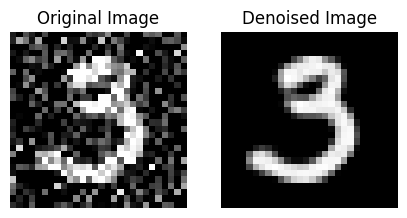

In [32]:
# visualizing the denoised image

def visualize_denoised_image(model, img):
    model.eval()
    output = model(img/255)
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output.squeeze(0).detach().numpy(), cmap='gray')
    plt.title('Denoised Image')
    plt.axis('off')

visualize_denoised_image(autoencoder_model, noisy_train_dataset[1][0])

In [37]:
def train_cnn(train_dataset, val_dataset,autoencoder_model,epochs=10, batch_size=128, lr=0.001, dropout=0.2, kernel_size=5, stride=1, padding=2, verbose=True):
    # before giving the images to the cnn, we will first pass the images through the autoencoder to denoise while training
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    model = CNN(kernel_size=kernel_size, dropout=dropout, stride=stride, padding=padding)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = autoencoder_model(inputs/255)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)
        if verbose:
            print('Epoch: ', epoch + 1, 'Train Loss: ', train_loss[-1], 'Train Accuracy: ', train_acc[-1])
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs = autoencoder_model(inputs/255)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)
        if verbose:
            print('Epoch: ', epoch + 1, 'Validation Loss: ', val_loss[-1], 'Validation Accuracy: ', val_acc[-1])
    return train_loss, val_loss, train_acc, val_acc,model

In [38]:
# training the cnn using the denoised images
train_loss, val_loss, train_acc, val_acc,denoised_model = train_cnn(noisy_train_dataset, noisy_val_dataset,autoencoder_model, epochs=10, batch_size=128, lr=0.001, dropout=0.2, kernel_size=5, stride=1, padding=2, verbose=True)

Epoch:  1 Train Loss:  0.3497791103399394 Train Accuracy:  0.88862
Epoch:  1 Validation Loss:  0.10346977287738383 Validation Accuracy:  0.9672
Epoch:  2 Train Loss:  0.10970097803570272 Train Accuracy:  0.9679
Epoch:  2 Validation Loss:  0.0750716261365274 Validation Accuracy:  0.9763
Epoch:  3 Train Loss:  0.08232790817175527 Train Accuracy:  0.97568
Epoch:  3 Validation Loss:  0.059586371277470754 Validation Accuracy:  0.9812
Epoch:  4 Train Loss:  0.06722796703105235 Train Accuracy:  0.97984
Epoch:  4 Validation Loss:  0.05984589822378151 Validation Accuracy:  0.9819
Epoch:  5 Train Loss:  0.05535061458897446 Train Accuracy:  0.98348
Epoch:  5 Validation Loss:  0.0564138171722806 Validation Accuracy:  0.9828
Epoch:  6 Train Loss:  0.04843738716562538 Train Accuracy:  0.98538
Epoch:  6 Validation Loss:  0.04729040470740557 Validation Accuracy:  0.9858
Epoch:  7 Train Loss:  0.04243170138974876 Train Accuracy:  0.9869
Epoch:  7 Validation Loss:  0.05239512558578502 Validation Accurac

In [40]:
def test_cnn(test_dataset, model,autoencoder_model):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = autoencoder_model(images/255)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted)
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: ', correct / total)
    print('Classification Report: ')
    print(classification_report(y_true, y_pred))
    print('Per-class accuracy: ')
    print(per_class_accuracy(y_true, y_pred))

test_cnn(noisy_test_dataset, denoised_model,autoencoder_model)

Accuracy of the network on the test images:  0.9871
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Per-class accuracy: 
[0.9959183673469387, 0.9929515418502203, 0.997093023255814, 0.9930693069306931, 0.9837067209775967, 0.9865470852017937, 0.9791231732776617, 0.98